In [1]:
import numpy as np
import os
import scanpy as sc
import matplotlib.pyplot as plt

# Load endoderm data

In [2]:
ad_fname = os.path.join("..", "gut_endoderm", "rnaseq", "data", "E85_endoderm_processed.h5ad")
ad = sc.read(ad_fname)

print(ad)

AnnData object with n_obs × n_vars = 21478 × 20897
    obs: 'Cluster', 'Timepoint', 'CellType', 'labels'
    uns: 'CellType_colors', 'diffmap_evals', 'labels_colors', 'neighbors', 'pca'
    obsm: 'FDL', 'X_diffmap', 'X_pca', 'X_tsne', 'X_umap', 'raw_counts'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


/Users/chooz/miniconda3/envs/lllvm/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/Users/chooz/miniconda3/envs/lllvm/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


In [5]:
del ad.uns["labels_colors"]

# Show force-directed layout

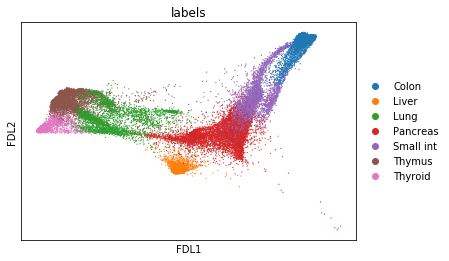

In [6]:
sc.pl.embedding(ad, basis="FDL", color="labels")

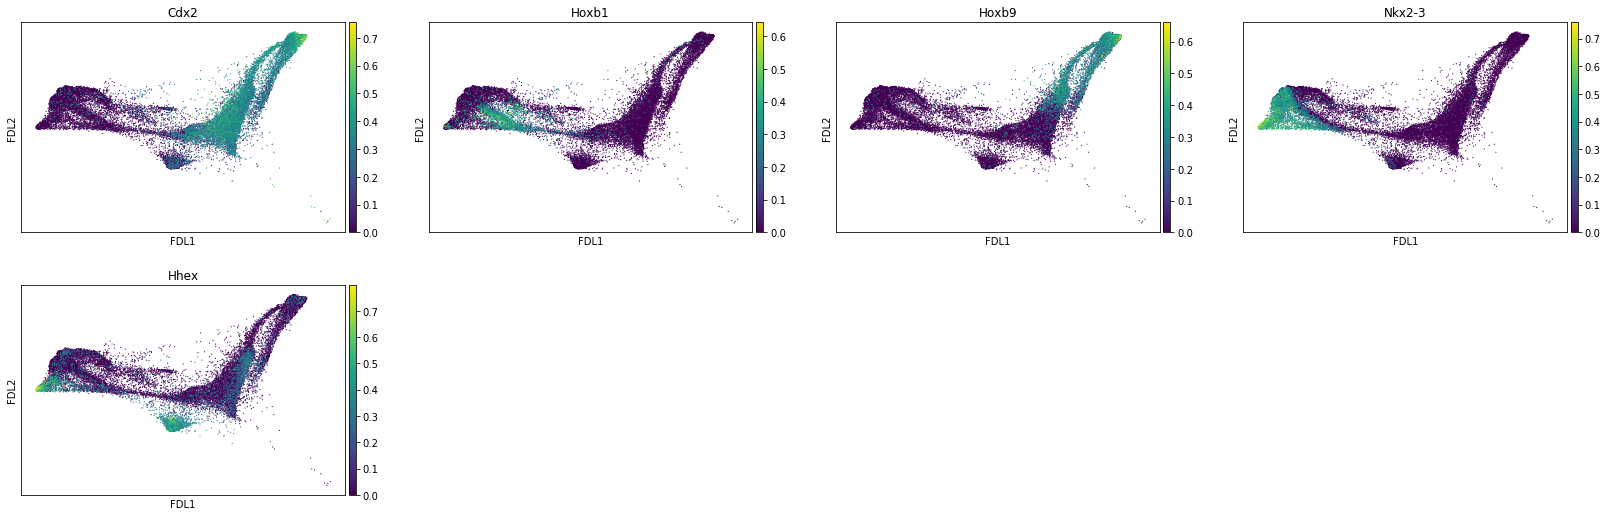

In [7]:
sc.pl.embedding(ad, basis="FDL", color=["Cdx2", "Hoxb1", "Hoxb9", "Nkx2-3", "Hhex"])

# Build input graph

In [9]:
from importlib import reload
import build_graph # script for building shared NN graph
import metacells # script for finding metacells

# input to graph construction is PCA/SVD
kernel_model = build_graph.MetacellGraph(ad.obsm["X_pca"], verbose=True)

# K is a sparse matrix representing input to metacell alg
K = kernel_model.rbf()

Computing kNN graph...
Computing radius for adaptive bandwidth kernel...



Making graph symmetric...
Computing RBF kernel...



Building similarity LIL matrix...



Constructing CSR matrix...


# Find metacells

In [21]:
reload(metacells)

# set number of metacells
N_METACELLS = 700
graph_model = metacells.Metacells(n_metacells=N_METACELLS)

# use K from above
graph_model.fit(K);

Initializing residual matrix
Initializing f and g...



Starting iteration 1 of 8
Completed iteration 0 of 8.
Starting iteration 2 of 8
Completed iteration 1 of 8.
Starting iteration 3 of 8
Completed iteration 2 of 8.
Starting iteration 4 of 8
Completed iteration 3 of 8.
Starting iteration 5 of 8
Completed iteration 4 of 8.
Starting iteration 6 of 8
Completed iteration 5 of 8.
Starting iteration 7 of 8
Completed iteration 6 of 8.
Starting iteration 8 of 8
Completed iteration 7 of 8.


# Show locations of centers on force-directed graph

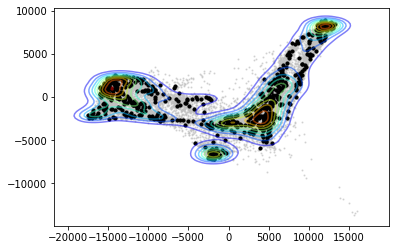

In [22]:
import seaborn as sns

ix = 20

cx = graph_model.get_centers()
Y = ad.obsm["FDL"]

sns.kdeplot(Y[:,0], Y[:,1], alpha=0.5, cmap="jet")

plt.scatter(Y[:,0], Y[:,1], c="silver", alpha=0.5, marker=".", s=5.)
plt.scatter(Y[cx,0], Y[cx,1], c="k", s=10., marker="o")

# Make sure cell types are all represented

In [23]:
from collections import Counter
import pandas as pd

# get labels of model centers
archetype_labels = ad[cx].obs.Cluster.values
archetype_clusters = ad[cx].obs.labels.values

# get counts for clusters and labels for archetypes
archetype_label_counts = Counter(archetype_labels)
archetype_cluster_counts = Counter(archetype_clusters)

# get counts for all cells
all_label_counts = Counter(ad.obs.Cluster.values)
all_clusters = Counter(ad.obs.labels.values)

# unzip
labels, lcounts = zip(*archetype_label_counts.items())
clusters, ccounts = zip(*archetype_cluster_counts.items())
all_labels, all_lcounts = zip(*all_label_counts.items())
all_clusters, all_ccounts = zip(*all_clusters.items())

# normalize
lcounts = lcounts / np.sum(lcounts)
ccounts = ccounts / np.sum(ccounts)
all_lcounts = all_lcounts / np.sum(all_lcounts)
all_ccounts = all_ccounts / np.sum(all_ccounts)

# dset
lcounts_dset = np.concatenate([np.array(["archetypes"] * len(lcounts)), 
                       np.array(["all"] * len(all_lcounts))])

ccounts_dset = np.concatenate([np.array(["archetypes"] * len(ccounts)), 
                       np.array(["all"] * len(all_ccounts))])

# make into dataframe
label_df = pd.DataFrame({"labels": np.concatenate([labels, all_labels]),
           "counts": np.concatenate([lcounts, all_lcounts]),
           "data": lcounts_dset})

cluster_df = pd.DataFrame({"labels": np.concatenate([clusters, all_clusters]),
           "counts": np.concatenate([ccounts, all_ccounts]),
           "data": ccounts_dset})

Text(0.5, 1.0, 'Frequency by cell type')

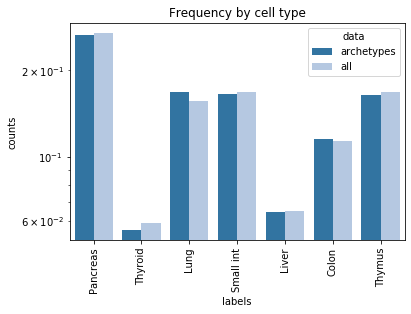

In [24]:
sns.barplot(x="labels", y="counts", hue="data", data=cluster_df, palette="tab20")
plt.title("Frequency by PhenoGraph cluster")

plt.xticks(rotation=90)
plt.yscale("log")
plt.title("Frequency by cell type")

#  Show sizes

Text(0.5, 1.0, 'Hard cluster size')

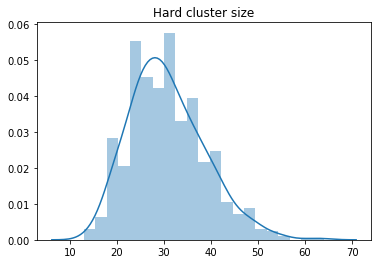

In [31]:
from collections import Counter
sizes = graph_model.get_sizes()#Counter(np.argmax(graph_model.A_, axis=0))
sns.distplot([_ for _ in sizes.values()])
plt.title("Hard cluster size")

# Get metacell coordinates and make metacell AnnData

In [21]:
# create A for hard clusters
# A = np.zeros_like(model.A_)
# A[np.argmax(model.A_, axis=0), np.arange(model.A_.shape[1])] = 1.

In [34]:
# import util
# from sklearn.preprocessing import LabelEncoder

# encode clusters and cell type
# celltype_encoder = LabelEncoder()
# encoded_celltypes = celltype_encoder.fit_transform(ad.obs.labels.values)
# cluster_encoder = LabelEncoder()
# encoded_clusters = cluster_encoder.fit_transform(ad.obs.Cluster.values)

# get cluster labels for metacells
# metacell_celltypes = celltype_encoder.inverse_transform(util.transfer_labels(model.A_, encoded_celltypes))
metacell_celltypes = ad.obs.labels.values[cx]
# metacell_clusters = cluster_encoder.inverse_transform(util.transfer_labels(model.A_, encoded_clusters))

# get metacell sizes
metacell_sizes = sizes#model.A_.sum(axis=1)

Get gene expression corresponding w each metacell (can take a while to run )

In [35]:
# get coordinates
coords = graph_model.get_coordinates(ad.obsm["raw_counts"])
#A @ ad.obsm["raw_counts"]
#model.get_coordinates(ad.obsm["raw_counts"])

In [37]:
# create AnnData
metacell_ad = sc.AnnData(coords)
metacell_ad.var = ad.var
metacell_ad.obs_names = ad.obs_names[cx]

# metacell_ad
metacell_ad.obs["labels"] = metacell_celltypes
# metacell_ad.obs["Cluster"] = metacell_clusters
metacell_ad.obs["size"] = metacell_sizes

## Visualize

In [38]:
# store raw counts
metacell_ad.obsm["raw_counts"] = metacell_ad.X.copy()

# normalize and visualize
sc.pp.normalize_total(metacell_ad)
sc.pp.log1p(metacell_ad)

sc.tl.pca(metacell_ad)
sc.pp.neighbors(metacell_ad, n_neighbors=15)
sc.tl.diffmap(metacell_ad)
sc.tl.draw_graph(metacell_ad)

In [39]:
print(metacell_ad)

AnnData object with n_obs × n_vars = 700 × 20897
    obs: 'labels', 'size'
    uns: 'log1p', 'pca', 'neighbors', 'diffmap_evals', 'draw_graph'
    obsm: 'raw_counts', 'X_pca', 'X_diffmap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


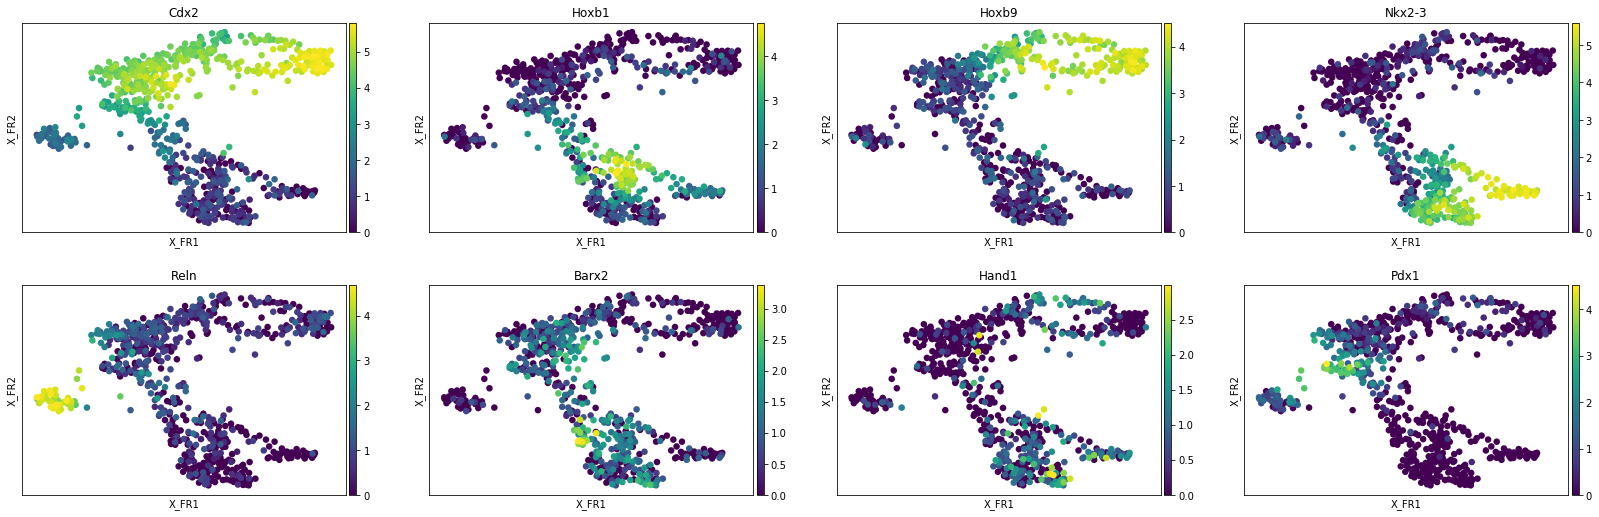

In [47]:
sc.pl.embedding(metacell_ad, basis="X_draw_graph_fr", color=["Cdx2", "Hoxb1", "Hoxb9", "Nkx2-3", 
                                                             "Reln", "Barx2", "Hand1", "Pdx1"])

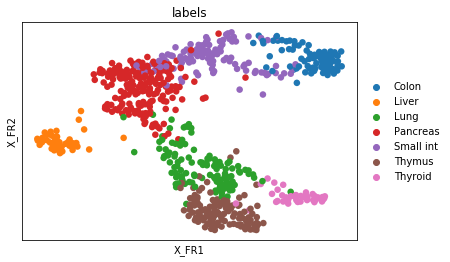

In [41]:
sc.pl.embedding(metacell_ad, basis="X_draw_graph_fr", color="labels")

In [48]:
metacell_ad.obs

,labels,size
index,,
Lib11-2_E8.5_GFP+_GTACTCCGTCAGAAGC,Pancreas,179
Lib12-1_E8.5_GFP-_TGCGCAGCACGCCAGT,Thyroid,593
Lib11-1_E8.5_GFP+_TGGTTAGCAATCCGAT,Lung,623
Lib11-1_E8.5_GFP+_TTGGCAAGTATCACCA,Small int,245
Lib12-2_E8.5_GFP-_GAACCTATCTGAGGGA,Lung,300
...,...,...
Lib11-2_E8.5_GFP+_CACCAGGTCATGCTCC,Pancreas,94
Lib12-2_E8.5_GFP-_GTTACAGTCTGTCCGT,Small int,644
Lib12-2_E8.5_GFP-_GACCAATTCTTCCTTC,Thymus,279


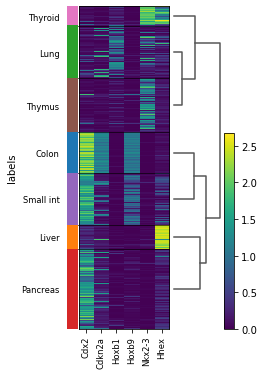

In [40]:
keys = ["Cdx2", "Cdkn2a", "Hoxb1", "Hoxb9", "Nkx2-3", "Hhex"]
sc.pl.heatmap(metacell_ad, var_names=keys, groupby="labels", dendrogram=True);

# Save data and assignments

In [42]:
# save stuff
outfile = os.path.join("..", "ot", "data", "gut_tube", "rna_archetypes.h5ad")

# not normalized or log transformed
metacell_ad.write_h5ad(outfile)

In [44]:
# write archetype map
import pandas as pd
cell_names = ad.obs_names
archetype_assignments = ad.obs_names[cx[np.argmax(model.A_, axis=0)]]

archetype_map = pd.DataFrame({"cell": cell_names, "archetype": archetype_assignments})

archetype_map

,cell,archetype
0,Lib11-1_E8.5_GFP+_TTTATGCAGTATCTCG,Lib11-1_E8.5_GFP+_GTCTTCGAGCGTGAAC
1,Lib11-1_E8.5_GFP+_TTTATGCAGTGCGTGA,Lib11-1_E8.5_GFP+_ATAGACCGTCAAAGCG
2,Lib11-1_E8.5_GFP+_TTTATGCAGAAGCCCA,Lib11-1_E8.5_GFP+_TGGTTAGAGCCTTGAT
3,Lib11-1_E8.5_GFP+_TTTATGCAGAGGTAGA,Lib11-1_E8.5_GFP+_GGTATTGGTACTTAGC
4,Lib11-1_E8.5_GFP+_TTTATGCAGCGCTTAT,Lib11-1_E8.5_GFP+_GAGGTGATCAGCTCTC
...,...,...
21473,Lib12-2_E8.5_GFP-_CCCAGTTGTGCACTTA,Lib12-2_E8.5_GFP-_TGAGCATCATTCTCAT
21474,Lib12-2_E8.5_GFP-_CCCAGTTCATTCCTCG,Lib12-2_E8.5_GFP-_CCCAGTTCATTCCTCG
21475,Lib12-2_E8.5_GFP-_CCCAGTTCATAGACTC,Lib12-2_E8.5_GFP-_GTGAAGGGTACCGTAT
21476,Lib12-2_E8.5_GFP-_CCCAGTTCATGGTTGT,Lib12-2_E8.5_GFP-_GACTAACGTAAACGCG


In [45]:
archetype_map_outfile = os.path.join("..", "ot", "data", "gut_tube", "rna_archetypes_map.csv")
archetype_map.to_csv(archetype_map_outfile, index=False)